Install

In [34]:
!pip install --upgrade pandas
!pip install --upgrade gensim
!pip install --upgrade pythainlp
!pip install --upgrade pyLDAvis
!pip install text2emotion
!pip install fairseq
!pip install sacremoses sentencepiece
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.4)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
Requirement already up-to-date: pythainlp in /usr/local/lib/python3.7/dist-packages (2.3.1)
Requirement already up-to-date: pyLDAvis in /usr/local/lib/python3.7/dist-packages (3.3.1)
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Created wheel for pythainlp: filename=pythainlp-2.3.1-cp37-none-any.whl size=11617551 sha256=d85faa03aa3814e6287d3d16b63e57f478c227195c89e0d1491e00fc80118511
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovh_rvqf/wheels/79/4e/1e/26f3198c6712ecfbee92928ed1dde923a078da3d222401cc78
Successfully built pythainlp


In [35]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import pandas as pd
import numpy as np
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import pythainlp 
from pythainlp.translate import EnThTranslator, ThEnTranslator
from pythainlp.translate import download_model_all
from pythainlp.corpus.common import *
from pythainlp.util import normalize
from pythainlp import Tokenizer
download_model_all()

import text2emotion as te

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import gensim
from gensim import corpora, models, similarities, downloader

Import source data

In [36]:
url = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/012d3c593aefc5821bd07d549674f5cae46c2fcc/HOMEWORK%2011/CustomerReviews.csv'
df = pd.read_csv(url)
df.head(5)

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0


# Tokenize Words

In [37]:
# Build thai words for tokenizer
th_words = []
th_words.extend(list(thai_words())) 
th_words.extend(list(thai_stopwords()))
th_words.extend(list(thai_negations()))
th_words.extend(list(countries()))
th_words.extend(list(provinces()))

# add additional words
from pathlib import Path

url_a1 = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/8001618620975c53c1742535958c124fdf207bef/HOMEWORK%2011/add_words.txt'
url_a2 = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/8001618620975c53c1742535958c124fdf207bef/HOMEWORK%2011/add_places.txt'
add_words = pd.read_fwf(url_a1, header=None)
add_places = pd.read_fwf(url_a2, header=None)
# additional words
th_words.extend(str(add_words).split('|')) 
th_words.extend(str(add_places).split('|')) 
th_words = set(th_words)

# remove from result list
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n','/n/n','/n', '(', ')', ':', '–', '"', ',','🤣','😆']
screening_words = stopwords + removed_words

def tokenize_with_space(text):
  text = normalize(str(text))
  custom_tokenizer = Tokenizer(th_words)
  words = custom_tokenizer.word_tokenize(text=text)
  words = [x for x in words if (x not in removed_words)]
  print(words)
  merged = ''
  for word in words:
    word = normalize(word)
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [38]:
print(list(pythainlp.corpus.thai_stopwords()))

['นับแต่นั้น', 'มิ', 'นี่นา', 'ทั้งเป็น', 'ด้วยเหตุนี้', 'เสียนี่', 'อันจะ', 'ขณะใดๆ', 'จัด', 'จากนั้น', 'เป็นการ', 'แล้ว', 'ทํา', 'ช่วงที่', 'เกี่ยวข้อง', 'พบ', 'เมื่อก่อน', 'ส่วนดี', 'พื้นๆ', 'ทว่า', 'ครบครัน', 'เช่นที่ว่า', 'ถึงเมื่อใด', 'ทุกคน', 'ค่อนข้าง', 'ถึงแม้ว่า', 'ด้วยเช่นกัน', 'เช่นดังเก่า', 'วันนั้น', 'ใหญ่ๆ', 'เมื่อคืน', 'ในเมื่อ', 'ตลอดเวลา', 'เล็กน้อย', 'เช่นนั้นเอง', 'ยิ่งขึ้นไป', 'พร้อมกัน', 'คง', 'เกือบ', 'เฉกเช่น', 'เสียยิ่ง', 'จวบจน', 'เสร็จสิ้น', 'ยืนยง', 'เคย', 'รึว่า', 'เท่า', 'จัดตั้ง', 'ให้', 'กำหนด', 'ทุกวัน', 'เพื่อให้', 'ได้ที่', 'ยืนยัน', 'คิดว่า', 'เข้า', 'เช่นกัน', 'พา', 'นั่นเป็น', 'ต่อกัน', 'ผิด', 'กล่าว', 'ได้แก่', 'ทุก', 'หลาย', 'ตามด้วย', 'นาย', 'ช่วงก่อน', 'เป็นเพื่อ', 'แค่นี้', 'ยังโง้น', 'ก็ต่อเมื่อ', 'ก็ตาม', 'ที่ใด', 'เกือบๆ', 'อีก', 'ครบถ้วน', 'บาง', 'จริงๆ', 'บัดนี้', 'ทุกสิ่ง', 'เห็นควร', 'เลย', 'ช้า', 'เสร็จ', 'เปลี่ยน', 'ทุกคราว', 'ใช่ไหม', 'ยังงี้', 'ยังคง', 'ช่วงท้าย', 'หน', 'เพิ่ม', 'เชื่อมั่น', 'นอก', 'ด้วยที่', 'ด้วยเหตุที่', 'ยังแต่'

In [39]:
df['Review_tokenized'] = df['Review'].apply(lambda x: tokenize_with_space(x))
df

['ที่', 'สำคัญ', 'ของ', 'ร้าน', 'นี้', 'คือ', 'บริการ', 'ดีมาก', 'พนักงาน', 'น่ารัก', 'สุดๆ', 'สะอาดสะอ้าน', 'ใส่ใจ', 'ค่อนข้าง', 'ประทับใจ', 'กับ', 'การ', 'บริการ', 'รสชาติ', 'อาหาร', 'อันนี้', 'แปลกใหม่', 'เซ็ท', '560', 'บาท', 'อาหาร', 'จำกัด', 'ไม่', 'ได้', 'หลากหลาย', 'แต่เพียง', 'พอกับ', 'ความต้องการ', 'เรา', 'ไม่', 'กิน', 'เนื้อ', 'กิน', 'สัน', 'คอ', '4', 'ถาด', 'เป็ด', '1', 'แฟน', 'กิน', 'เนื้อ', 'คุณภาพดี', 'น้ำ', 'ซุป', 'ดำ', 'กับ', 'เผ็ด', 'ที่', 'สำคัญ', 'คือ', 'น้ำจิ้ม', 'อร่อย', 'มาก', 'ไม่', 'เคย', 'กิน', 'รสชาติ', 'แบบนี้', 'มา', 'ก่อน', 'เป็น', 'เต้าเจี้ยว', 'นิดๆ', 'แต่ก็', 'ไม่', 'ได้', 'เคลม', 'ก็', 'รสชาติ', 'ดี', 'นะ', 'ถาม', 'ราคา', 'โดยรวม', 'ก็', 'ถือว่า', 'คุ้ม', 'เพราะว่า', 'โมจิ', 'อร่อย', 'มาก', 'ไอติม', 'ก็', 'อร่อย', 'ไม่ต้อง', 'ออก', 'ไป', 'กิน', 'ข้างนอก', 'สรุป', 'รวมๆ', 'ละ', 'กัน', 'ว่า', 'ประทับใจ', 'ใน', 'บริการ', 'และ', 'คุณภาพ', 'ของ', 'อาหาร']
['นึกถึง', 'ชาบู', 'ญี่ปุ่น', 'ยังไง', 'ก็', 'ต้อง', 'คิดถึง', 'โมโม่', 'พาราไดซ์', 'คุณภาพ', 'เค้า', 'ม

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating,Review_tokenized
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0,"ร้าน,บริการ,ดีมาก,พนักงาน,น่ารัก,สะอาดสะอ้าน,ใ..."
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0,"นึกถึง,ชาบู,ญี่ปุ่น,คิดถึง,โมโม่,พาราไดซ์,คุณภ..."
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0,"ทาน,นั่ง,โต๊ะ,หม้อ,โต๊ะ,ยังมี,ฉาก,กั้น,น้ำ,ซุป..."
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0,"นึกถึง,ชาบู,เนื้อ,ราคา,โหด,เกินไป,นึกถึง,โมโม่..."
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0,"เดิน,หน้า,ร้าน,ได้กลิ่น,ชาบู,หอ,มมาก,โปร,บัตรเ..."
5,6,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,12f2b56b28bb4849a92690cedc1cc50a,กินให้อิ่ม ที่ momo,ร้านบุฟเฟ่ ชาบูแนวญี่ปุ่น สายเนื้อหมู เนื้อวัว...,4.0,"ร้าน,บุฟเฟ่,ชาบู,แนว,ญี่ปุ่น,สาย,เนื้อหมู,เนื้..."
6,7,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,f2628bf47a394345b133fec76a79661d,ชาบู - สุกกี้สไลต์ญี่ปุ่นที่แท้ทรู,Number 20 : โมโม – พาราไดส์ (สาขาเดอะมอลบางกะป...,4.0,"Number,20,โม,โม,พารา,ได,ส์,สาขา,เดอะ,มอ,ล,บางก..."
7,8,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,backscrash,ร้านชาบูเฟรนไชส์ ที่ราคาเหมาะสมกับคุณภาพ ถือว่...,ร้านชาบูเฟรนไชส์รสชาติดีมากคุ้มค่าเหมาะสมกับรา...,4.0,"ร้าน,ชาบู,เฟรนไชส์,รสชาติ,ดีมาก,คุ้มค่า,เหมาะส..."
8,9,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,a477a5812ada4d5b80fd04fca22bdbca,อร่อยคุ้ม ของทานเล่นเยอะมาก,มา านที่ขาบูชิต้องมาตอนหิว ไม่งั้นจะไม่คุ้มนะค...,4.0,"มาน,ขา,บู,ชิ,ตอน,หิว,ไม่งั้น,คุ้ม,ฮ่า,เมนู,ของ..."
9,10,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,fd2ba94ec1bc4948ae109e2cb6c9cbc6,ทานอีก ชอบกุ้งทอดเทมปุระ,ใครชอบกุ้งทอดเทมปุระ แค่กุ้งเทมปุระก็คุ้มแล้ว ...,3.0,"ชอบ,กุ้ง,ทอด,เท,ม,ปุระ,กุ้ง,เท,ม,ปุระ,คุ้ม,ทาน..."


# Simple words count

In [40]:
df1 = df
df1 = (df1['Review_tokenized'].str.split(pat=',', expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))
print (df1)

            vals  count
0           ร้าน     32
1            น้ำ     28
2            ทาน     25
3            กิน     23
4          อร่อย     22
..           ...    ...
598          บดี      1
599        เบคอน      1
600  เปรี้ยวหวาน      1
601         ร้อน      1
602                   1

[603 rows x 2 columns]


# Text to Emotion

In [41]:
df2 = df
df2['Trans'] = df2['Review'].apply(lambda x: ThEnTranslator().translate(x))
df2['Emotion'] = df2['Trans'].apply(lambda x: te.get_emotion(x))
df2[['Review','Trans','Emotion']].head()

,Review,Trans,Emotion
0,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,What's important about this restaurant is very...,"{'Happy': 0.45, 'Angry': 0.05, 'Surprise': 0.0..."
1,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,Think of Japanese shabu tea anyways. Think of ...,"{'Happy': 0.32, 'Angry': 0.0, 'Surprise': 0.21..."
2,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,You can sit at the same table with the same po...,"{'Happy': 0.06, 'Angry': 0.11, 'Surprise': 0.0..."
3,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,If you're thinking about a full-on teabu at an...,"{'Happy': 0.12, 'Angry': 0.12, 'Surprise': 0.5..."
4,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,Walked up to the store and smelled a lot of ch...,"{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.0,..."


# Create Dictionary



In [42]:
documents = df['Review_tokenized'].to_list()
texts = [[text for text in doc.split(',')] for doc in documents]
texts = [x for x in texts if (x not in removed_words)]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['1', '4', '560', 'กิน', 'ข้างนอก', 'ความต้องการ', 'คอ', 'คุณภาพ', 'คุณภาพดี', 'คุ้ม', 'จำกัด', 'ซุป', 'ดำ', 'ดี', 'ดีมาก', 'ถาด', 'ถาม', 'น่ารัก', 'น้ำ', 'น้ำจิ้ม', 'บริการ', 'บาท', 'ประทับใจ', 'พนักงาน', 'พอกับ', 'รสชาติ', 'ราคา', 'ร้าน', 'สรุป', 'สะอาดสะอ้าน', 'สัน', 'หลากหลาย', 'อร่อย', 'อันนี้', 'อาหาร', 'เคลม', 'เซ็ท', 'เต้าเจี้ยว', 'เนื้อ', 'เป็ด', 'เผ็ด', 'แบบนี้', 'แปลกใหม่', 'แฟน', 'โดยรวม', 'โมจิ', 'ใส่ใจ', 'ไม่ต้อง', 'ไอติม', '21', '30', '9', 'CTW', 'Terminal', 'กา', 'การงด', 'คิดถึง', 'ชาบู', 'ญี่ปุ่น', 'ฐาน', 'ทะยอย', 'ทำงาน', 'ที่ทาง', 'นาที', 'นึกถึง', 'พนักงานบริการ', 'พระราม', 'พรีเมียม', 'พาราไดซ์', 'มาตรา', 'มีโอ', 'รายละเอียด', 'ลูกค้า', 'สมาทาน', 'สาขา', 'สู้', 'ออร์เดอร์', 'เครื่องดื่ม', 'เค้า', 'เจอ', 'เป็นกันเอง', 'เหวี่ยง', 'แจ้ง', 'โมโม่', 'โอเค', '++', '2', '555', '600', '::', 'กก', 'กรุบ', 'กั้น', 'ของหวาน', 'คนละ', 'คาว', 'คุ', 'คุ้มค่า', 'จาน', 'จิ้ม', 'จืด', 'ฉาก', 'ชอบ', 'ชาเขียว', 'ชิ้น', 'ซอย', 'ซอส', 'ตก', 'ตะ', 'ตัก', 'ตามน้ำ', 'ต่างกัน', 

In [43]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in texts]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]

In [44]:
num_topics = 4
chunksize = 1000 # size of the doc looked at every pass
passes = 50 # number of passes through documents
iterations = 20
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, per_word_topics=True )

In [45]:
df['topics'] = df['Review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['Review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df[['Review','topics','score']].tail()

,Review,topics,score
16,หลังจากที่เคยลองสาขายูเนี่ยนมอลล์ไป รอบนี้มาที...,2,0.999232
17,ร้านบุฟเฟ่ต์ที่มีโปรโมชั่นหัวละ199บาท ไม่รวมน้...,1,0.999271
18,เคยรู้จักร้านนี้จากที่ union mall ไม่เคยได้ลอง...,3,0.998879
19,อร่อยมากค่ะ คุ้มค่าสมราคา บุฟเฟ่หมูผักต่างๆ รว...,0,0.998729
20,ก็ตามที่เขียนเลยครับ ว่า ถ้าจะจ่ายในราคา 199 บ...,3,0.998337


# Display Topic Model

In [46]:
vis = pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.107463  0.042570       1        1  36.307599
3      0.034700 -0.089214       2        1  27.879080
0      0.098501  0.071403       3        1  20.682405
2     -0.025738 -0.024759       4        1  15.130917, topic_info=      Term       Freq      Total Category  logprob  loglift
331      -  10.000000  10.000000  Default  30.0000  30.0000
11     ซุป  12.000000  12.000000  Default  29.0000  29.0000
268   กุ้ง   9.000000   9.000000  Default  28.0000  28.0000
21     บาท  10.000000  10.000000  Default  27.0000  27.0000
131     สด   7.000000   7.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
74    สาขา   1.309878   9.720669   Topic4  -5.0773  -0.1159
13      ดี   1.309879  13.177425   Topic4  -5.0773  -0.4201
38   เนื้อ   1.309879  14.439133   Topic4  -5.0773  -0.5116
148  เลือก   1.309879  14.680707   Topic4  -5.0773  -0.5282
32   อร่อย   1.309880  16.634366   Topic4  -5.0773  -0.6531

[268 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
208       1  0.361920      +
208       3  0.361920      +
331       3  0.684639      -
331       4  0.195611      -
266       4  0.791153     ..
...     ...       ...    ...
165       1  0.900419    ไม้
330       2  0.942943   ไลน์
48        1  0.460732  ไอติม
48        2  0.307155  ไอติม
48        3  0.153577  ไอติม

[328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

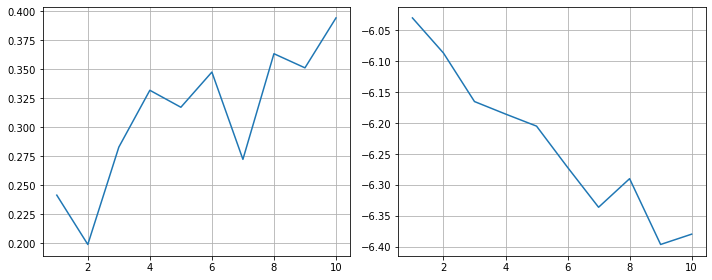

In [47]:
score = []
for k in range(1,11):
    model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, 
                        alpha='auto', eta='auto', 
                        iterations=iterations, num_topics=k, 
                        passes=passes, eval_every=eval_every)
    coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    score.append((k,coherence_model_lda.get_coherence(),model.log_perplexity(gensim_corpus)))

x, y, z = zip(*score)
plt.figure(figsize=(10,4), tight_layout=True)
plt.subplot(121)
plt.plot(x, y, label='Coherence')
plt.grid(True)
plt.subplot(122)
plt.plot(x, z, label='perplexity')
plt.grid(True)
plt.show()